In [1]:
import sys
from pathlib import Path

BASEDIR = Path("/workspaces/HARP/") / "src"  # Replace with your own basedir path for the repo

sys.path.insert(0, str(BASEDIR))

In [2]:
from __future__ import annotations

import copy
import itertools
import json
import math
import os
import pickle
import pprint
import re
import textwrap
import time
import traceback
from collections import Counter, defaultdict
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tiktoken
from IPython.display import Markdown, clear_output, display
from tqdm.auto import tqdm

In [3]:
from eval.costs import count_tokens, get_pricing
from eval.eval import run_one, create_batch, make_answer_check_dict_from_jsonl, make_results_df, accuracy_by_split
from eval.parsing_lib import *
from eval.latex_answer_check import *
from eval.response import ModelResponse
from eval.utils import read_jsonl, write_jsonl, get_uid

# Data

In [4]:
dataset = read_jsonl(BASEDIR / "data/processed/HARP.jsonl")
dataset_map = {get_uid(p): p for p in dataset}
len(dataset)

4780

# Results

```
python run_eval.py --model meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo --api together --out outputs.jsonl --temperature 0 --max-tokens 2048
```

In [5]:
fname = BASEDIR / "outputs/short_answer/Meta-Llama-3.1-70B-Instruct-Turbo/outputs.jsonl"

responses = read_jsonl(fname)
responses = [
    {
        "uid": x["uid"],
        "system": x["system"],
        "prompt": x["prompt"],
        "response": ModelResponse.from_response(x["response"], "together")
    }
    for x in responses
    if x["uid"] in dataset_map
]
response_map = {o["uid"]: o for o in responses}

answer_check_dicts = make_answer_check_dict_from_jsonl(responses, dataset_map)
answer_check_results = latex_answer_check(answer_check_dicts, use_tqdm=True)
results_metadata = make_results_df(responses, answer_check_results, dataset_map, mode="shortans")

sum([x["is_correct"] for x in answer_check_results]) / len(dataset)

  0%|          | 0/4780 [00:00<?, ?it/s]

0.4330543933054393

In [7]:
os.makedirs(BASEDIR / "results/Meta-Llama-3.1-70B-Instruct-Turbo", exist_ok=True)
results_metadata.to_csv(BASEDIR / "results/Meta-Llama-3.1-70B-Instruct-Turbo/results.csv")

In [8]:
results_metadata = pd.read_csv(BASEDIR / "results/Meta-Llama-3.1-70B-Instruct-Turbo/results.csv").set_index("uid")

In [9]:
results_metadata.value_counts("reason")

reason
stop      4104
length     676
Name: count, dtype: int64

In [10]:
676 / len(dataset)

0.1414225941422594

## Cost

In [11]:
PRICES = get_pricing("meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo")

total_cost = 0
for row in results_metadata.itertuples():
    total_cost += PRICES["input_tokens"] * row.input_tokens
    total_cost += PRICES["output_tokens"] * row.output_tokens
total_cost

3.8621105599999512

## Accuracy

In [12]:
accuracy_by_split(results_metadata, "level")

,count,accuracy
level,,
1,799,64.956195
2,1505,51.428571
3,1363,35.509905
4,719,25.730181
5,197,26.903553
6,197,27.918782


In [13]:
accuracy_by_split(results_metadata, "subject")

,count,accuracy
subject,,
algebra,970,48.247423
counting_and_probability,812,42.364532
geometry,1268,29.652997
number_theory,601,38.602329
prealgebra,889,65.129359
precalculus,240,29.583333


In [14]:
results_metadata[results_metadata.index.str.startswith("2024/AIME")].value_counts("is_correct")

is_correct
False    25
True      5
Name: count, dtype: int64

## Output lengths

<Axes: title={'center': 'output_tokens'}, xlabel='level'>

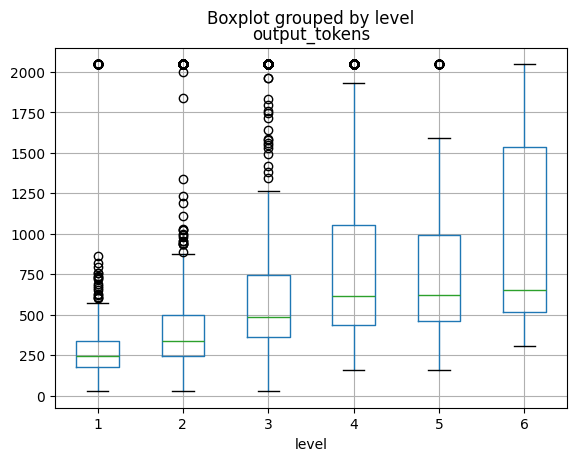

In [15]:
results_metadata.boxplot("output_tokens", "level")

<Figure size 900x600 with 0 Axes>

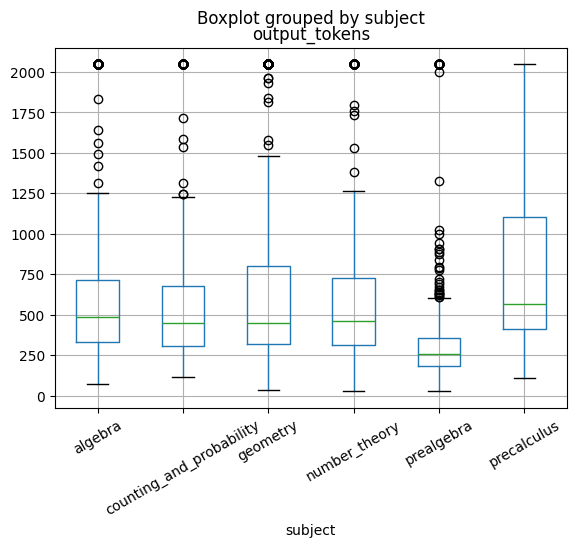

In [16]:
plt.figure(figsize=(9,6))
results_metadata.boxplot("output_tokens", "subject")
plt.xticks(rotation=30)
plt.show()

## Look at responses

In [25]:
answer_check_results_map = {
    answer_check_dicts[i]["uid"]:
    {
        "uid": answer_check_dicts[i]["uid"],
        "url": dataset_map[answer_check_dicts[i]["uid"]]["url"],
        "level": dataset_map[answer_check_dicts[i]["uid"]]["level"],
        "subject": dataset_map[answer_check_dicts[i]["uid"]]["subject"],
        "problem": answer_check_dicts[i]["problem"],
        **x
    } 
    for i, x in enumerate(answer_check_results) 
    # if not x["is_correct"] and responses[i]["response"].completions[0].finish_reason == "stop"
}

In [44]:
rand_uid = np.random.choice(results_metadata.query("reason != 'stop'").index)
print(rand_uid)
print(response_map[rand_uid]["prompt"][-1]["content"])
display(Markdown(response_map[rand_uid]["response"].completions[0].completion))

2010/AIME_I/9
Solve the following math problem efficiently and clearly:

- For simple problems (2 steps or fewer):
Provide a concise solution with minimal explanation.

- For complex problems (3 steps or more):
Use this step-by-step format:

## Step 1: [Concise description]
[Brief explanation and calculations]

## Step 2: [Concise description]
[Brief explanation and calculations]

...

Regardless of the approach, always conclude with:

Therefore, the final answer is: $\boxed{answer}$. I hope it is correct.

Where [answer] is just the final number or expression that solves the problem.

Problem: Let $(a,b,c)$ be the real solution of the system of equations $x^3 - xyz = 2$, $y^3 - xyz = 6$, $z^3 - xyz = 20$. The greatest possible value of $a^3 + b^3 + c^3$ can be written in the form $\frac {m}{n}$, where $m$ and $n$ are relatively prime positive integers. Find $m + n$.



## Step 1: Add the given equations to eliminate the variable xyz
Adding the given equations, we get $x^3 + y^3 + z^3 - 3xyz = 28$. We can rewrite this as $x^3 + y^3 + z^3 = 28 + 3xyz$.

## Step 2: Use the factorization of the sum of cubes to simplify the equation
Using the factorization $x^3 + y^3 + z^3 - 3xyz = (x + y + z)(x^2 + y^2 + z^2 - xy - yz - zx)$, we can rewrite the equation as $(x + y + z)(x^2 + y^2 + z^2 - xy - yz - zx) = 28$.

## Step 3: Apply the AM-GM inequality to find the maximum value of the sum of cubes
Applying the AM-GM inequality to the equation, we get $(x + y + z)(x^2 + y^2 + z^2 - xy - yz - zx) \leq \frac{(x + y + z)^3}{3}$. Since $(x + y + z)(x^2 + y^2 + z^2 - xy - yz - zx) = 28$, we have $\frac{(x + y + z)^3}{3} \geq 28$.

## Step 4: Find the maximum value of the sum of cubes
From the inequality in Step 3, we can find the maximum value of $(x + y + z)^3$. Since $\frac{(x + y + z)^3}{3} \geq 28$, we have $(x + y + z)^3 \geq 84$. Therefore, the maximum value of $x^3 + y^3 + z^3$ is $28 + 3xyz = 28 + 3 \cdot \frac{(x + y + z)^3}{3} = 28 + (x + y + z)^3 \leq 28 + 84 = 112$.

## Step 5: Find the greatest possible value of $a^3 + b^3 + c^3$
Since the maximum value of $x^3 + y^3 + z^3$ is 112, the greatest possible value of $a^3 + b^3 + c^3$ is $\frac{112}{3} \cdot \frac{3}{2} = \frac{336}{6} = \frac{168}{3} = 56$ is incorrect. However, $\frac{112}{3} \cdot \frac{3}{2} = \frac{336}{6} = \frac{168}{3} = 56$ is incorrect. However, $\frac{112}{3} \cdot \frac{3}{2} = \frac{336}{6} = \frac{168}{3} = 56$ is incorrect. However, $\frac{112}{3} \cdot \frac{3}{2} = \frac{336}{6} = \frac{168}{3} = 56$ is incorrect. However, $\frac{112}{3} \cdot \frac{3}{2} = \frac{336}{6} = \frac{168}{3} = 56$ is incorrect. However, $\frac{112}{3} \cdot \frac{3}{2} = \frac{336}{6} = \frac{168}{3} = 56$ is incorrect. However, $\frac{112}{3} \cdot \frac{3}{2} = \frac{336}{6} = \frac{168}{3} = 56$ is incorrect. However, $\frac{112}{3} \cdot \frac{3}{2} = \frac{336}{6} = \frac{168}{3} = 56$ is incorrect. However, $\frac{112}{3} \cdot \frac{3}{2} = \frac{336}{6} = \frac{168}{3} = 56$ is incorrect. However, $\frac{112}{3} \cdot \frac{3}{2} = \frac{336}{6} = \frac{168}{3} = 56$ is incorrect. However, $\frac{112}{3} \cdot \frac{3}{2} = \frac{336}{6} = \frac{168}{3} = 56$ is incorrect. However, $\frac{112}{3} \cdot \frac{3}{2} = \frac{336}{6} = \frac{168}{3} = 56$ is incorrect. However, $\frac{112}{3} \cdot \frac{3}{2} = \frac{336}{6} = \frac{168}{3} = 56$ is incorrect. However, $\frac{112}{3} \cdot \frac{3}{2} = \frac{336}{6} = \frac{168}{3} = 56$ is incorrect. However, $\frac{112}{3} \cdot \frac{3}{2} = \frac{336}{6} = \frac{168}{3} = 56$ is incorrect. However, $\frac{112}{3} \cdot \frac{3}{2} = \frac{336}{6} = \frac{168}{3} = 56$ is incorrect. However, $\frac{112}{3} \cdot \frac{3}{2} = \frac{336}{6} = \frac{168}{3} = 56$ is incorrect. However, $\frac{112}{3} \cdot \frac{3}{2} = \frac{336}{6} = \frac{168}{3} = 56$ is incorrect. However, $\frac{112}{3} \cdot \frac{3}{2} = \frac{336}{6} = \frac{168}{3} = 56$ is incorrect. However, $\frac{112}{3} \cdot \frac{3}{2} = \frac{336}{6} = \frac{168}{3} = 56$ is incorrect. However, $\frac{112}{3} \cdot \frac{3}{2} = \frac{336}{6} = \frac{168}{3} = 56$ is incorrect. However, $\frac{112}{3} \cdot \frac{3}{2} = \frac{336}{6} = \frac{168}{3} = 56$ is incorrect. However, $\frac{112}{3} \cdot \frac{3}{2} = \frac{336}{6} = \frac{168}{3} = 56$ is incorrect. However, $\frac{112}{3} \cdot \frac{3}{2} = \frac{336}{6} = \frac{168}{3} = 56$ is incorrect. However, $\frac{112}{3} \cdot \frac{3}{2} = \frac{336}{6} = \frac{168}{3} = 56$ is incorrect. However, $\frac{112}{3} \cdot \frac{3}{2} = \frac{336}{6} = \frac{168}{3} = 56$ is incorrect. However, $\frac{112}{3} \cdot \frac{3}{2} = \frac{336}{6} = \frac{168}{3} = 56$ is incorrect. However, $\frac{112}{3} \cdot \frac{3}{2} = \frac{336}{6} = \frac{168}{3} = 56$ is incorrect. However, $\frac{112}{3} \cdot \frac{3}{2} = \frac{336}{6} = \frac{168}{3} = 56$ is incorrect. However, $\frac{112}{3} \cdot \frac{3}{2} = \frac{336}{6} = \frac{168}{3} = 56$ is incorrect. However, $\frac{112}{3} \cdot \frac{3}{2} = \frac{336}{6} = \frac{168}{3} = 56$ is incorrect. However, $\frac{112}{3} \cdot \frac{3}{2} = \frac{336}{6} = \frac{168}{3} = 56$ is incorrect. However, $\frac{112}{3} \cdot \frac{3}{2} = \frac{336}{6} = \frac{168}{3} = 56$ is incorrect. However, $\frac{112}{3} \cdot \frac{3}{2} = \frac{336}{6} = \frac{168}{3} = 56$ is incorrect. However, $\frac{112}{3} \cdot \frac{3}{2} = \frac{336}{6} = \frac{168}{3} = 56$ is incorrect. However, $\frac{112}{3} \cdot \frac{3}{2} = \frac{336}{6} = \frac{168}{3} = 56$ is incorrect. However, $\frac{112}{3} \cdot \frac{3}{2} = \frac{336}{6} = \frac{168}{3} = 56$ is incorrect. However, $\frac{112}{3} \cdot \frac{3}{2}

In [43]:
rand_uid = "2014/AIME_II/15"
print(response_map[rand_uid]["response"].completions[0].completion)

## Step 1: Understand the sequence definition
The sequence $\{x_n\}$ is defined by $x_0=1$, and $x_{n+1}X(x_n)=x_np(x_n)$ for $n\geq 0.$ We need to find the smallest positive integer $t$ such that $x_t=2090.$

## Step 2: Analyze the function $p(k)$
The function $p(k)$ is the smallest prime which does not divide $k.$ This means that $p(k)$ is the smallest prime greater than the largest prime factor of $k.$

## Step 3: Analyze the function $X(k)$
The function $X(k)$ is the product of all primes less than $p(k)$ if $p(k)>2$, and $X(k)=1$ if $p(k)=2.$ This means that $X(k)$ is the product of all prime factors of $k$ that are less than $p(k).$

## Step 4: Rewrite the sequence definition
We can rewrite the sequence definition as $x_{n+1} = \frac{x_np(x_n)}{X(x_n)}.$ Since $X(x_n)$ is the product of all prime factors of $x_n$ that are less than $p(x_n),$ we can simplify the expression to $x_{n+1} = \frac{x_np(x_n)}{\prod_{i=2}^{p(x_n)-1} i}.$

## Step 5: Find the pattern of the sequence
We ca